<a href="https://colab.research.google.com/github/secoxx/IE423/blob/main/task_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Required Libraries for Analysis

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np
from datetime import datetime, timedelta

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading the data

In [67]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/electricity/continuous dataset.csv')
X_train = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/data/electricity/train_dataframes.xlsx')
X_test = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/data/electricity/test_dataframes.xlsx')

In [89]:
(X_train['datetime'].min())

TypeError: 'Timestamp' object cannot be interpreted as an integer

In [107]:
X_test.tail()

,datetime,week_X-2,week_X-3,week_X-4,MA_X-4,dayOfWeek,weekend,holiday,Holiday_ID,hourOfDay,T2M_toc,DEMAND
163,2019-04-19 20:00:00,1343.4547,1343.3746,1430.9092,1372.579500,7,0,1,9,20,28.373438,1169.1743
164,2019-04-19 21:00:00,1281.4317,1295.9271,1401.2511,1326.203300,7,0,1,9,21,27.841547,1156.5246
165,2019-04-19 22:00:00,1219.6607,1257.8020,1331.1551,1269.539267,7,0,1,9,22,27.478448,1133.0677
166,2019-04-19 23:00:00,1176.6818,1203.6749,1292.4117,1224.256133,7,0,1,9,23,27.187463,1098.2215
167,2019-04-20 00:00:00,1120.9486,1136.1685,1244.7380,1167.285033,1,1,1,10,0,26.972650,1078.8903


### Initial Data Check

In [68]:
df.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


### Checking the size of the data

In [69]:
df.shape

(48048, 17)

### Dealing Missing Values

In [70]:
df.isnull().sum()

datetime      0
nat_demand    0
T2M_toc       0
QV2M_toc      0
TQL_toc       0
W2M_toc       0
T2M_san       0
QV2M_san      0
TQL_san       0
W2M_san       0
T2M_dav       0
QV2M_dav      0
TQL_dav       0
W2M_dav       0
Holiday_ID    0
holiday       0
school        0
dtype: int64

### Setting Data Frequency to Days

In [71]:
df.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [72]:
# Convert 'datetime' column to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Set 'datetime' column as index
df.set_index('datetime', inplace=True)


In [73]:
df=df.resample('D').sum()
df

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-03,24593.1315,640.258344,0.427781,0.150905,519.569774,609.063031,0.418404,0.251831,255.940291,570.688031,0.391480,2.069977,100.681001,0,0,0
2015-01-04,24194.9663,657.257361,0.431690,0.090911,564.750271,630.007361,0.427456,0.329913,290.178945,580.687048,0.404308,2.509796,119.145686,0,0,0
2015-01-05,27520.3902,652.187445,0.429726,0.320255,642.616327,624.546820,0.416191,0.386194,340.907093,577.890570,0.388703,2.361938,172.331271,0,0,0
2015-01-06,27441.4663,648.086310,0.417367,0.260336,635.801032,621.828497,0.412217,0.364853,331.314068,571.476935,0.384289,2.327942,167.013520,0,0,0
2015-01-07,27458.3716,640.282080,0.413809,0.419168,573.518487,604.930518,0.399961,0.602199,312.988475,557.836768,0.369955,2.498993,167.628326,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-23,27296.7922,677.091223,0.499111,1.546936,217.434105,656.966223,0.480595,1.711655,73.531054,602.544348,0.463505,3.370636,79.165583,0,0,24
2020-06-24,27148.7190,671.086188,0.476302,1.643997,152.787257,646.508063,0.466818,1.618042,109.518611,595.242438,0.432677,2.500519,53.031454,0,0,24
2020-06-25,28416.6890,668.991095,0.488515,0.903442,345.535306,650.350470,0.466001,2.820801,85.825540,600.616095,0.432767,4.508881,49.275876,0,0,24


### Converting Numeric Values to Appropriate Formats

In [77]:
df.select_dtypes(include='number').columns

Index(['nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san',
       'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav',
       'W2M_dav', 'Holiday_ID', 'holiday', 'school'],
      dtype='object')

In [78]:
# List of columns to convert to numeric
numeric_columns = ['nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san',
       'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav',
       'W2M_dav', 'Holiday_ID', 'holiday', 'school']

# Convert each column to numeric
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [112]:
df.tail()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2020-06-23,27296.7922,677.091223,0.499111,1.546936,217.434105,656.966223,0.480595,1.711655,73.531054,602.544348,0.463505,3.370636,79.165583,0,0,24
2020-06-24,27148.7190,671.086188,0.476302,1.643997,152.787257,646.508063,0.466818,1.618042,109.518611,595.242438,0.432677,2.500519,53.031454,0,0,24
2020-06-25,28416.6890,668.991095,0.488515,0.903442,345.535306,650.350470,0.466001,2.820801,85.825540,600.616095,0.432767,4.508881,49.275876,0,0,24
2020-06-26,26550.6647,663.389380,0.480911,2.121155,297.307662,634.655005,0.469054,2.674744,95.031686,583.483130,0.438621,4.606995,56.948678,0,0,24
2020-06-27,1013.5683,26.750330,0.020441,0.063965,10.198346,25.125330,0.019281,0.100189,2.785751,23.562830,0.018404,0.162598,3.286878,0,0,1


In [120]:
df['Holiday_ID'].unique()

array([  0,  48,  72,  96, 120, 144, 168, 192, 216, 240, 264, 288, 312,
       336, 360, 384, 408, 432, 456, 480, 504, 528,  24])

In [123]:
df['school'].unique()

array([ 0, 24,  1])

# Exploratory Data Analysis: Visual Overview Electricity Data

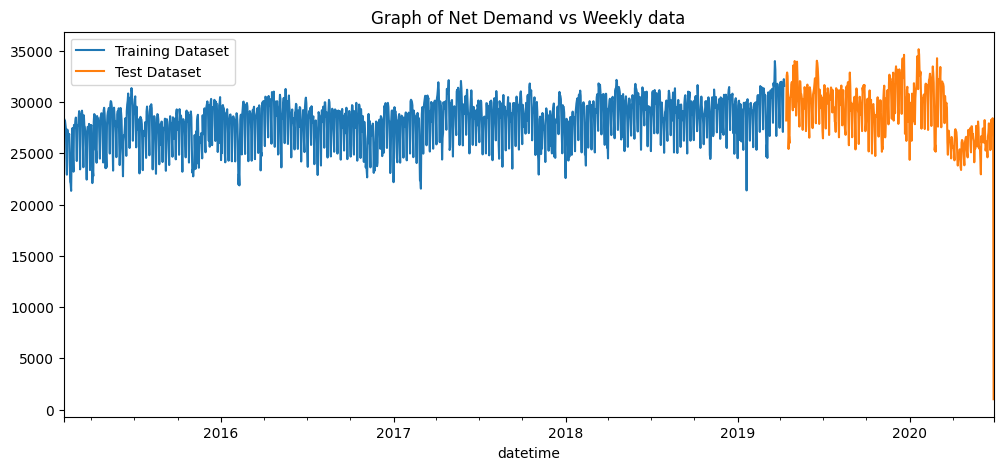

In [108]:
X_train['datetime'] = pd.to_datetime(X_train['datetime'])
X_test['datetime'] = pd.to_datetime(X_test['datetime'])
# Filter the dataframes
train_mask = (df.index >= X_train['datetime'].min()) & (df.index <= X_train['datetime'].max())
test_mask = (df.index >= X_test['datetime'].min()) & (df.index <= df.index.max())

# Plot the data
df.loc[train_mask, 'nat_demand'].plot(figsize=(12,5), legend=True)
df.loc[test_mask, 'nat_demand'].plot(figsize=(12,5), legend=True)
plt.legend(['Training Dataset', 'Test Dataset'])
plt.title('Graph of Net Demand vs Weekly data')
plt.show()

Let's zoom into the data and mark every Friday by vertical dotted lines.

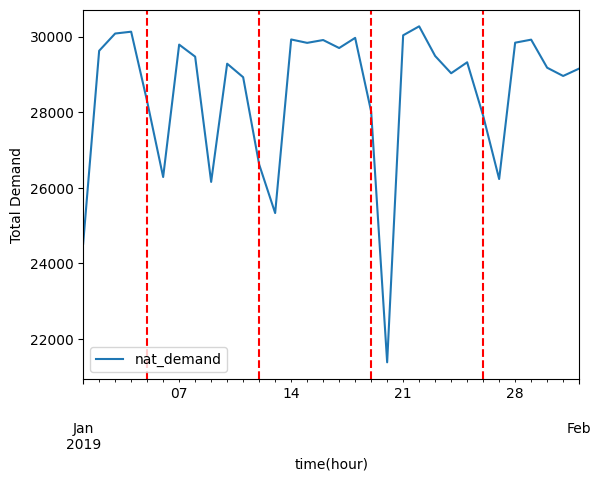

In [114]:

df[['nat_demand' ]]['2019-01-01': '2019-02-01'].plot()

plt.xlabel('time(hour)')
plt.ylabel('Total Demand')

# Adding vertical lines at the start of each week
min_date, max_date = df.index.min(), df.index.max()
current_date = min_date

while current_date <= max_date:
    if current_date.weekday() == 5:  # Monday is considered the start of the week
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(days=1)

### Computing Autocorrelation for the 'nat_demand' Column

Text(0.5, 1.0, 'ACF Plot')

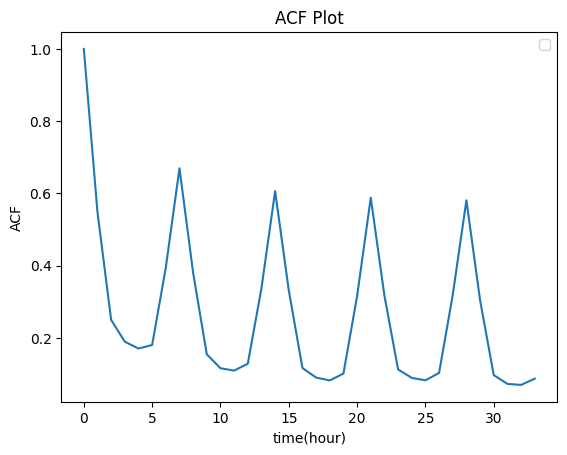

In [115]:

plt.plot(acf(df['nat_demand']))
plt.xlabel('time(hour)')
plt.ylabel('ACF')

plt.legend()
plt.title('ACF Plot')

Text(0, 0.5, 'Yearly Demand)')

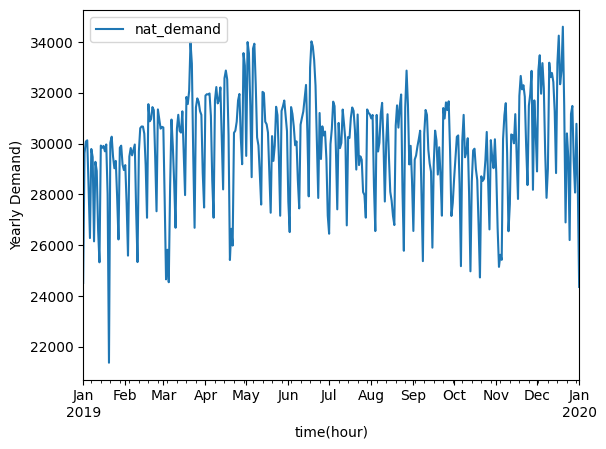

In [117]:
df[['nat_demand' ]]['2019-01-01': '2020-01-01'].plot()

plt.xlabel('time(hour)')
plt.ylabel('Yearly Demand')

<ipython-input-122-8ba8274d0f5a>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', len(unique_holidays))


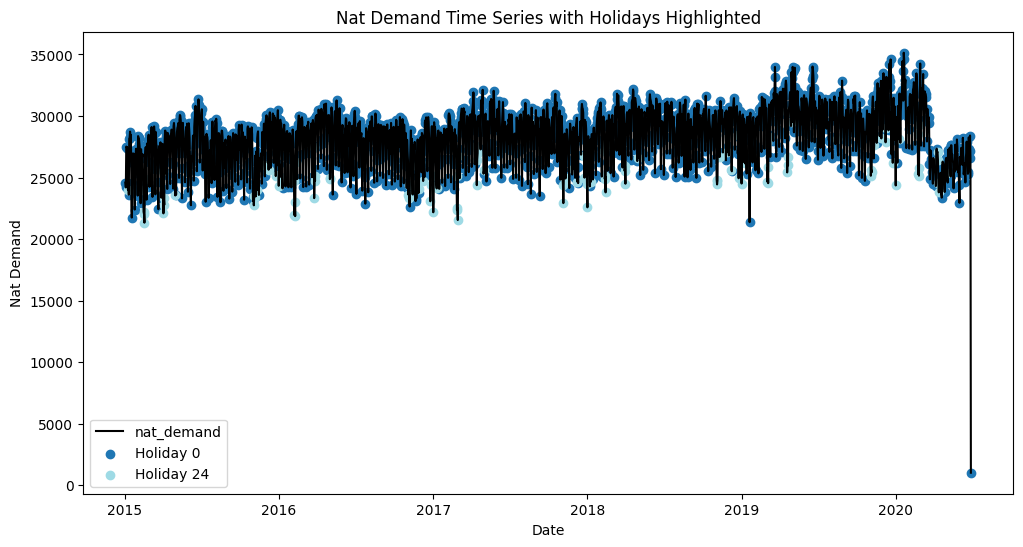

In [122]:
import matplotlib.cm as cm

# Get unique holidays and assign colors
unique_holidays = df['holiday'].unique()
colors = cm.get_cmap('tab20', len(unique_holidays))

# Create a dictionary mapping each holiday to a color
holiday_colors = {holiday: colors(i) for i, holiday in enumerate(unique_holidays)}

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['nat_demand'], label='nat_demand', color='black')

# Highlight holidays
for holiday_id, color in holiday_colors.items():
    holiday_data = df[df['holiday'] == holiday_id]
    plt.scatter(holiday_data.index, holiday_data['nat_demand'], color=color, label=f'Holiday {holiday_id}')

plt.xlabel('Date')
plt.ylabel('Nat Demand')
plt.title('Nat Demand Time Series with Holidays Highlighted')
plt.legend()
plt.show()

## Pie chart

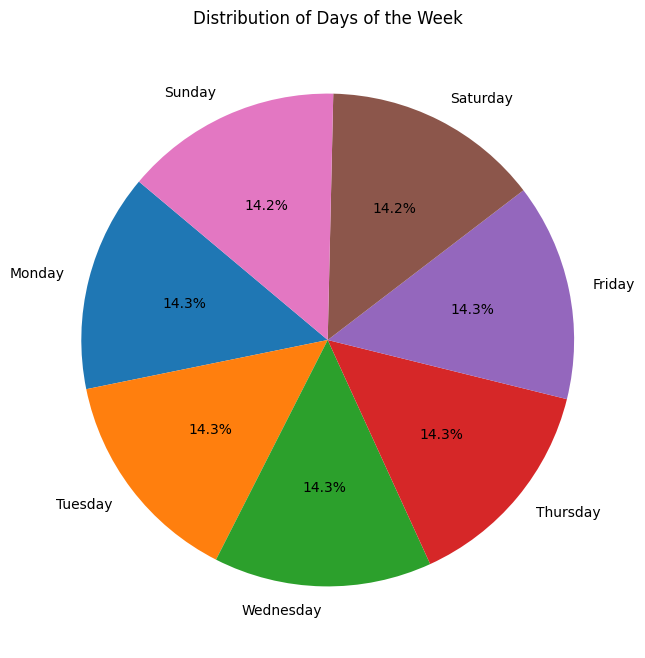

In [124]:
day_counts = X_train['dayOfWeek'].value_counts().sort_index()

# Define labels for the days of the week
labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(day_counts, labels=[labels[i] for i in day_counts.index], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Days of the Week')
plt.show()

We see an equal distribution among days of week.

# Modeling:
### Augmented Dickey-Fuller Test

The Augmented Dickey-Fuller (ADF) test is a statistical test used in time series analysis to determine whether a given time series is stationary or non-stationary. Stationarity is a crucial assumption for many time series modeling techniques.

The code below defines a function `adf_test(series, title='')` that performs the ADF test on a time series and provides a comprehensive report. The function takes the following parameters:

- `series`: The time series to be tested.
- `title` (optional): An optional title to label the ADF test.

The ADF test report includes the ADF test statistic, p-value, the number of lags used in the test, and the number of observations. Additionally, it compares the test statistic to critical values at various significance levels.

The test results are interpreted as follows:
- If the p-value is less than or equal to 0.05, there is strong evidence against the null hypothesis, indicating that the data is stationary, and the null hypothesis is rejected.
- If the p-value is greater than 0.05, there is weak evidence against the null hypothesis, suggesting that the data is non-stationary, and the null hypothesis is not rejected.

This ADF test function is a valuable tool for assessing the stationarity of time series data, a fundamental step in time series analysis and modeling.


In [125]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [126]:
adf_test(df['nat_demand'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -2.519102
p-value                    0.110896
# lags used               26.000000
# observations          1976.000000
critical value (1%)       -3.433664
critical value (5%)       -2.863004
critical value (10%)      -2.567549
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


## First Model: Exponential Smoothing
### Model Evaluation: Performance Assessment on Test Set

We already have the splitted data (it was provided along with the data)

In [129]:
# Convert 'datetime' column to datetime format
X_train['datetime'] = pd.to_datetime(X_train['datetime'])

# Set 'datetime' column as index
X_train.set_index('datetime', inplace=True)

# Convert 'datetime' column to datetime format
X_test['datetime'] = pd.to_datetime(X_test['datetime'])

# Set 'datetime' column as index
X_test.set_index('datetime', inplace=True)

In [130]:
X_train.head()

,week_X-2,week_X-3,week_X-4,MA_X-4,dayOfWeek,weekend,holiday,Holiday_ID,hourOfDay,T2M_toc,DEMAND
datetime,,,,,,,,,,,
2015-01-31 01:00:00,962.2865,906.9580,970.3450,938.004850,1,1,0,0,1,25.308496,954.2018
2015-01-31 02:00:00,933.3221,863.5135,912.1755,900.284075,1,1,0,0,2,25.141443,913.8660
2015-01-31 03:00:00,903.9817,848.4447,900.2688,881.704325,1,1,0,0,3,25.006738,903.3637
2015-01-31 04:00:00,900.9995,839.8821,889.9538,876.458825,1,1,0,0,4,24.899713,889.0806
2015-01-31 05:00:00,904.3481,847.1073,893.6865,879.190775,1,1,0,0,5,24.821558,910.1472


In [131]:
fitted_model = ExponentialSmoothing(X_train['DEMAND'],
                                    trend='add',
                                    seasonal='add',
                                    seasonal_periods=24).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


## Model Evaluation on Test Dataset


In [138]:
print(X_test.index.min())
print(X_test.index.max())

2019-04-13 01:00:00
2019-04-20 00:00:00


In [139]:
# Set the number of days for which the prediction is to be made
number_of_days = 7

# Calculate the total number of hours to predict based on the number of days
number_of_hours_to_predict = number_of_days * 24

# Extract the actual Gross Consumption data from the test dataset for the specified period
y = X_test['DEMAND']

# Use the fitted model to forecast the values for the specified number of hours and rename the output series to 'HW_Forecast'
test_predictions = fitted_model.forecast(number_of_hours_to_predict).rename('HW_Forecast')


### Visual Comparison of Train, Test, and Predicted Values
The following code snippet is designed to visually compare the Gross Consumption values across the training data, test data, and the model's predictions:

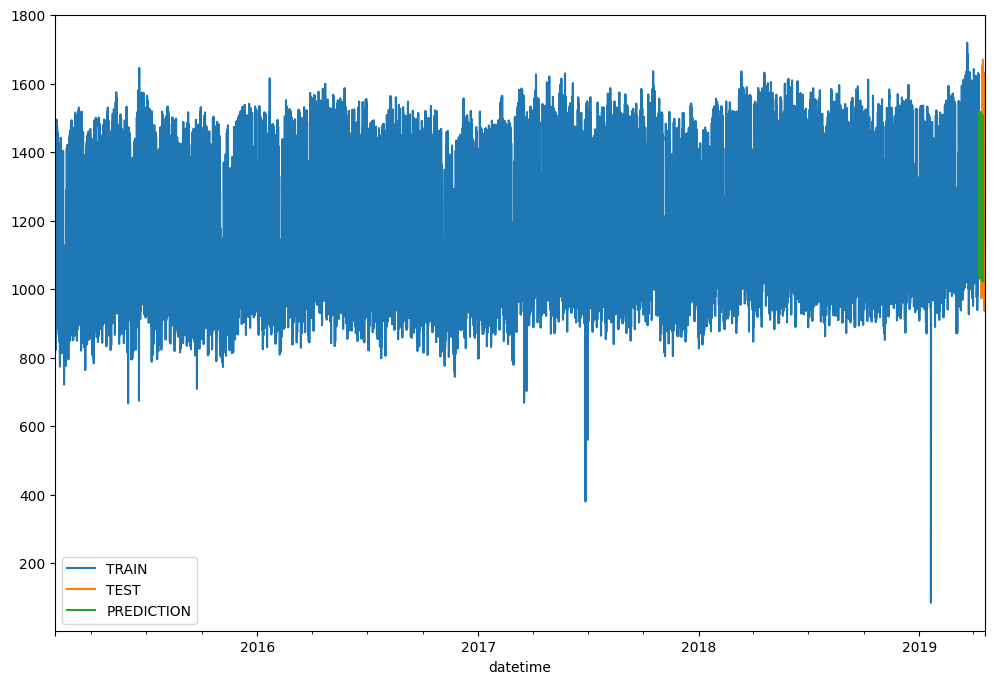

In [140]:
# Plotting the Gross Consumption from the training data
X_train['DEMAND'].plot(legend=True, label='TRAIN')

# Plotting the Gross Consumption from the test data
X_test['DEMAND'].plot(legend=True, label='TEST', figsize=(12,8))

# Plotting the predicted Gross Consumption values
test_predictions.plot(legend=True, label='PREDICTION');


To get a clearer comparison, let's zoom in on the plot:

<Axes: xlabel='datetime'>

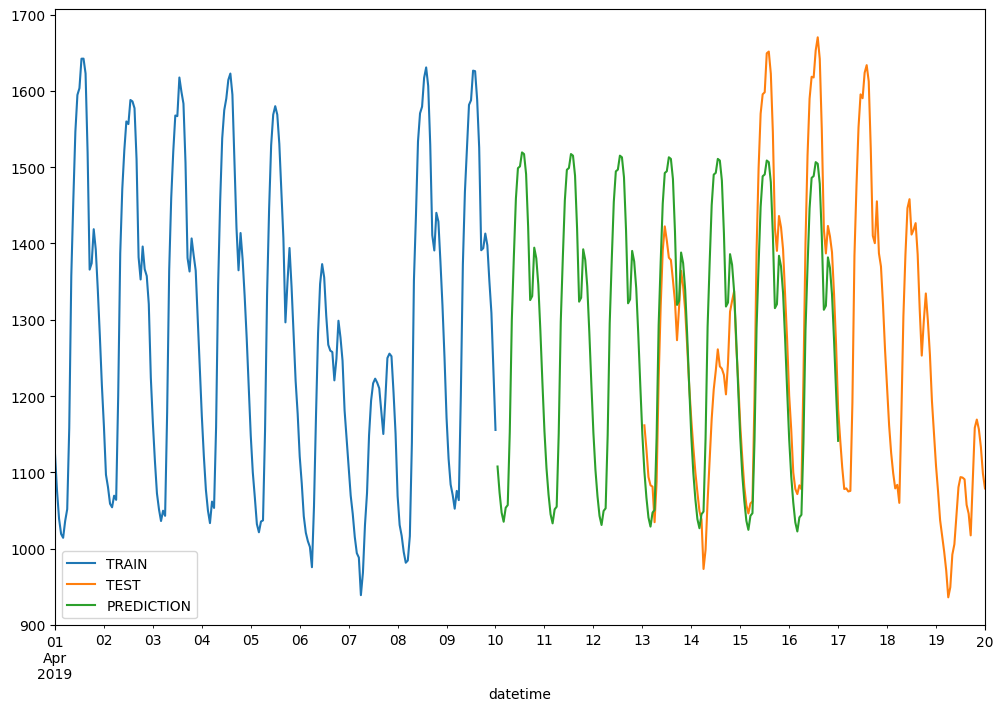

In [141]:
# Plotting the training data
X_train['DEMAND']['2019-04-01':].plot(legend=True, label='TRAIN')

# Plotting the testing data
X_test['DEMAND'][:'2019-04-20'].plot(legend=True, label='TEST', figsize=(12, 8))

# Plotting the predictions (first 200 points)
test_predictions[:200].plot(legend=True, label='PREDICTION')


The results seem to be effectively capturing the average values and the peaks, although they don't capture the nuances.

### Evaluation Metrics
In this section, we will calculate and present various evaluation metrics to assess the performance of our model. We are using the scikit-learn library to compute the following metrics:

#### Mean Absolute Error (MAE):


In [142]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y, test_predictions)
print("Mean Absolute Error:", mae)


Mean Absolute Error: 97.87474208585523


#### Mean Squared Error (MSE):



In [143]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y, test_predictions)
print("Mean Squared Error:", mse)


Mean Squared Error: 18441.393501160568


#### Root Mean Squared Error (RMSE):



In [144]:
import numpy as np
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)


Root Mean Squared Error: 135.79909241655693


The errors are more significant than what we hoped for. There's still room for improvement.

## Forecasting into the Future
### Exponential Smoothing
Although this model exhibited a notably high error, let's assess how it performs in predicting future values.

In [145]:
final_model = ExponentialSmoothing(X_train['DEMAND'],
                                    trend='add',
                                    seasonal='add',
                                    seasonal_periods=24).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: xlabel='datetime'>

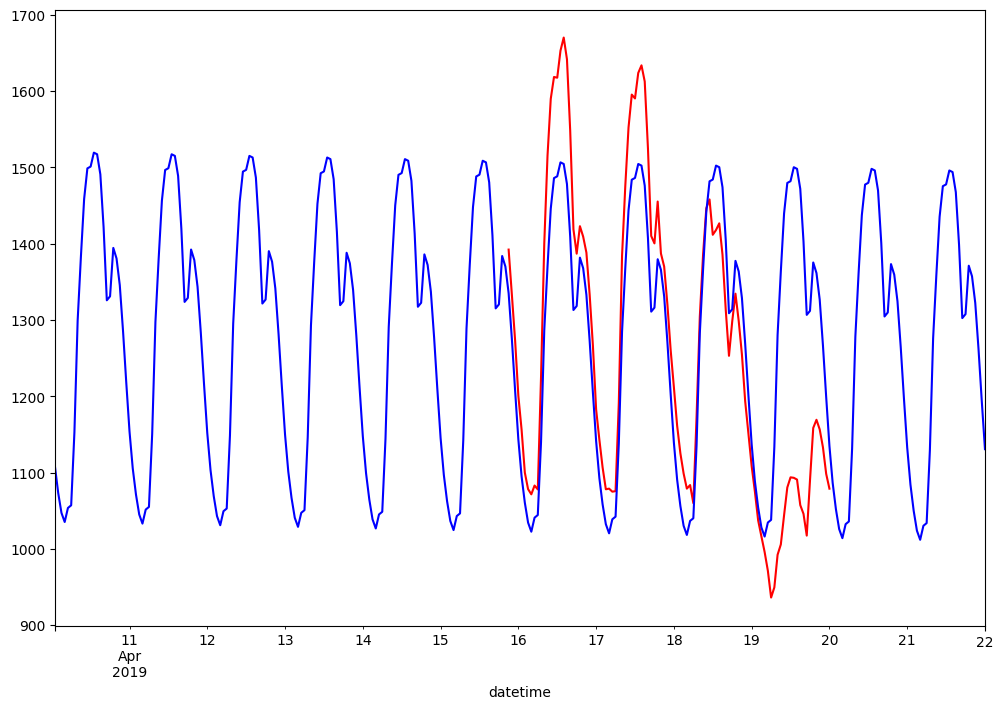

In [149]:
# Setting the number of days for the forecast
day_forecast = 12
hours_forecast = day_forecast * 24

# Generating forecast predictions
forecast_predictions = final_model.forecast(hours_forecast)

# Plotting the last 100 data points in red and the forecast in blue
X_test['DEMAND'][-100:].plot(figsize=(12, 8), color='red')
forecast_predictions.plot(color='blue')

This model seems to be capturing the pattern better. It captures the peaks.

## Autoregression (AR) Model




In [150]:
# Importing the Autoregression model from statsmodels library
from statsmodels.tsa.ar_model import AutoReg,ARResults

In [151]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [152]:
model = AutoReg(X_train['DEMAND'], lags=1)

In [153]:
ARfit = model.fit()

In [154]:
ARfit.params

const        59.036555
DEMAND.L1     0.949729
dtype: float64

In [156]:
# This is the general format for obtaining predictions
start=len(X_train['DEMAND'])
end=len(X_train['DEMAND'])+len(X_test['DEMAND'])-1
predictions1 = ARfit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

<Axes: xlabel='datetime'>

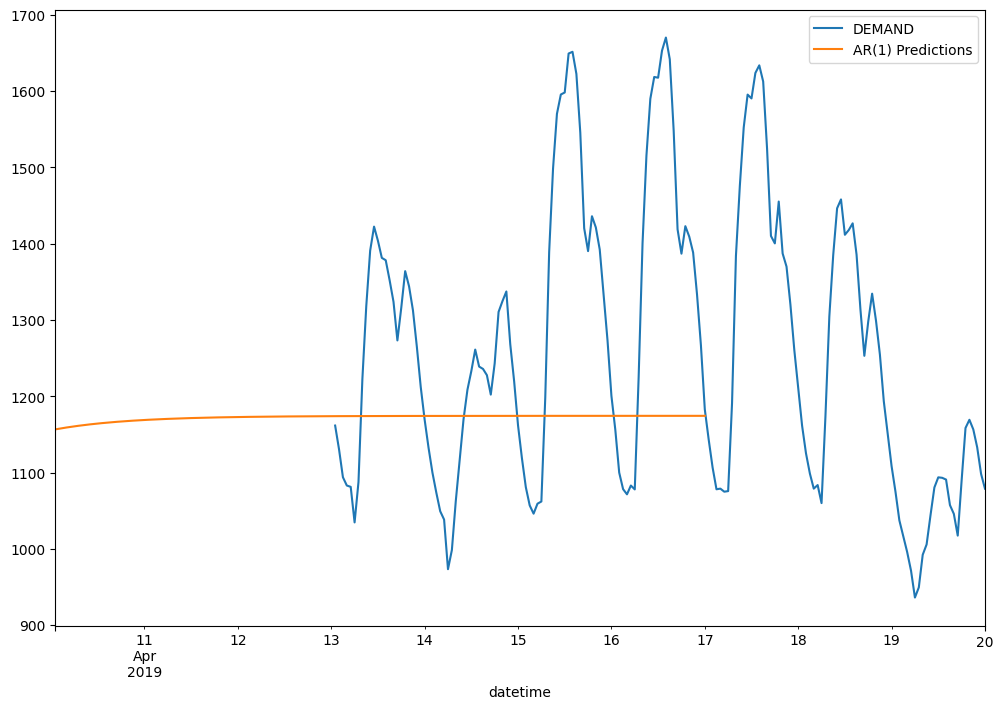

In [162]:
X_test['DEMAND'].plot(figsize=(12, 8), legend=True)
predictions1.plot(figsize=(12, 8), legend=True)

In [160]:

mae = mean_absolute_error(X_test['DEMAND'], predictions1)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 164.8724180317345


In [159]:
mse = mean_squared_error(X_test['DEMAND'], predictions1)
print("Mean Squared Error:", mse)


Mean Squared Error: 43032.56471023383


In [161]:
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 207.44291916147398


This model captures the average of the time series, but it doesn't capture any nuances. MSE, MAE and RMSE are significantly higher than the previous models.